In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy
import csv

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'bird', 'cat', 'deer'}
fg_used = '234'
fg1, fg2, fg3 = 2,3,4


all_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
background_classes = all_classes - foreground_classes
background_classes

# print(type(foreground_classes))

{'car', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck'}

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

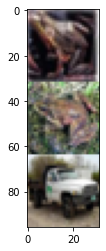

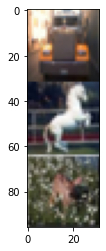

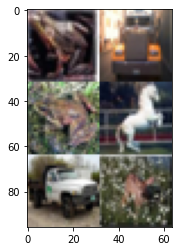

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)


3


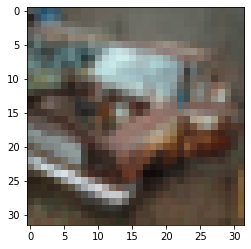

plane


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]]) 

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [0]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")
    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
      y = y.contiguous()


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.contiguous()
    y1 = y1.reshape(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y

In [0]:
fore_net = Module2().double()
fore_net = fore_net.to("cuda")

In [0]:
fore_net.load_state_dict(torch.load("/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch163_fg_used123.pt"))

<All keys matched successfully>

In [86]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 600

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  cnt=0
  mini_loss = []

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels, fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    # zero the parameter gradients
    
    # optimizer_what.zero_grad()
    # optimizer_where.zero_grad()
    optimizer.zero_grad()
    
    # avg_images , alphas = where_net(inputs)
    # avg_images = avg_images.contiguous()
    # outputs = what_net(avg_images)

    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    # optimizer_what.step()
    # optimizer_where.step()
    optimizer.step()
    running_loss += loss.item()
    mini = 40
  
    if cnt % mini == mini - 1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      mini_loss.append(running_loss / mini)
      running_loss = 0.0
      
    cnt=cnt+1
  if(np.average(mini_loss) <= 0.05):
    break
print('Finished Training')
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 1.334
[1,    80] loss: 0.962
[1,   120] loss: 0.895
[2,    40] loss: 0.844
[2,    80] loss: 0.816
[2,   120] loss: 0.814
[3,    40] loss: 0.765
[3,    80] loss: 0.763
[3,   120] loss: 0.733
[4,    40] loss: 0.703
[4,    80] loss: 0.715
[4,   120] loss: 0.721
[5,    40] loss: 0.675
[5,    80] loss: 0.712
[5,   120] loss: 0.705
[6,    40] loss: 0.649
[6,    80] loss: 0.671
[6,   120] loss: 0.659
[7,    40] loss: 0.612
[7,    80] loss: 0.651
[7,   120] loss: 0.645
[8,    40] loss: 0.619
[8,    80] loss: 0.639
[8,   120] loss: 0.629
[9,    40] loss: 0.603
[9,    80] loss: 0.616
[9,   120] loss: 0.618
[10,    40] loss: 0.568
[10,    80] loss: 0.618
[10,   120] loss: 0.601
[11,    40] loss: 0.576
[11,    80] loss: 0.599
[11,   120] loss: 0.618
[12,    40] loss: 0.557
[12,    80] loss: 0.576
[12,   120] loss: 0.574
[13,    40] loss: 0.535
[13,    80] loss: 0.555
[13,   120] loss: 0.602
[14,    40] loss: 0.551
[14,    80] loss: 0.553
[14,   120] loss: 0.619
[15,    40] loss: 0

In [0]:
# torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch"+str(epoch)+"_fg_used"+str(fg_used)+".pt")

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
test_set_labels = []
for i in range(10000):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)
  test_set_labels.append(set_idx)


In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [90]:
torch.argmax(alphas[5]), alphas[5]

(tensor(5, device='cuda:0', grad_fn=<NotImplemented>),
 tensor([0.0107, 0.2022, 0.1124, 0.0132, 0.0732, 0.4235, 0.1173, 0.0426, 0.0049],
        device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward>))

In [91]:
fg = [fg1, fg2, fg3]
all_list = [0,1,2,3,4,5,6,7,8,9]
bg = list(set(all_list)-set(fg))
fg, bg

([2, 3, 4], [0, 1, 5, 6, 7, 8, 9])

In [0]:
test_set = DataLoader( test_data,batch_size= batch ,shuffle=False)
train_set = DataLoader( msd,batch_size= batch ,shuffle=False)

#TRAIN SUMMARY

In [93]:
from tabulate import tabulate
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)
print(count)

print("="*100)
table3 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),30000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

train_entry = entry

table3.append(entry)

print(tabulate(table3, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 30000 train images: 98 %
total correct 29675
total train set images 30000
focus_true_pred_true 20242 =============> FTPT : 67 %
focus_false_pred_true 9433 =============> FFPT : 31 %
focus_true_pred_false 29 =============> FTPF : 0 %
focus_false_pred_false 296 =============> FFPF : 0 %
argmax_more_than_half 22596
argmax_less_than_half 7404
30000
  S.No.  fg_class        bg_class                      data_points     FTPT     FFPT       FTPF      FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  -------  -------  ---------  --------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000  67.4733  31.4433  0.0966667  0.986667            22596


#TEST SUMMARY

In [94]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

print("="*100)
table4 = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),10000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)

test_entry = entry 

table4.append(entry)

print(tabulate(table4, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 10000 test images: 70 %
total correct 7058
total train set images 10000
focus_true_pred_true 5644 =============> FTPT : 56 %
focus_false_pred_true 1414 =============> FFPT : 14 %
focus_true_pred_false 741 =============> FTPF : 7 %
focus_false_pred_false 2201 =============> FFPF : 22 %
argmax_more_than_half 7032
argmax_less_than_half 2968
  S.No.  fg_class        bg_class                      data_points    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  ------  ------  ------  ------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000   56.44   14.14    7.41   22.01             7032


#Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes separetly

In [95]:
from tabulate import tabulate
table1 = []
table1.append(train_entry)
entry_no = 2


# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in train_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 30000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table1.append(entry)
    entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(table1, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000    67.4733    31.4433  0.0966667   0.986667            22596
      2  fg = 2          bg = all_except_fg                   9980    69.9699    28.9279  0.0901804   1.01202              7816
      3  fg = 3          bg = all_except_fg                   9989    56.342     43.0173  0.0500551   0.59065              6604
      4  fg = 4          bg = all_except_fg                  10031    76.0742    22.4205  0.149536    1.3558               8176


In [96]:
# for testing_set
table2 = []
table2.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in test_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 10000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table2.append(entry)
    entry_no += 1

print("="*20+"Testing DATA"+"="*20)
print(tabulate(table2, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Testing DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000    56.44      14.14      7.41       22.01               7032
      2  fg = 2          bg = all_except_fg                   3371    55.6511    13.9128    8.03916    22.3969             2357
      3  fg = 3          bg = all_except_fg                   3283    57.1429    14.2553    6.67073    21.9312             2322
      4  fg = 4          bg = all_except_fg                   3346    56.5451    14.2558    7.50149    21.6975             2353


#Set Size 1 
##3 not in BG, 4 not in BG, 5 not in BG and so on
## On Training DATA


In [97]:
size1_table=[]
size1_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in train_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 30000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 not in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000    67.4733    31.4433  0.0966667   0.986667            22596
      2  fg = 2          bg != 0                              2823    68.8275    29.791   0.0708466   1.31066              2192
      3  fg = 2          bg != 1                              2932    67.5648    31.0027  0.102319    1.33015              2249
      4  fg = 2          bg != 5                              2991    72.317     26.8138  0.100301    0.768974             2385
      5  fg = 2          bg != 6                              2921    71.7562    27.5933  0.0342349   0.616227             2305
      6  fg = 2          bg != 7                  

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size1_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [99]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size1_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  0.986667          22596
1      2          fg = 2  ...  1.310662           2192
2      3          fg = 2  ...  1.330150           2249
3      4          fg = 2  ...  0.768974           2385
4      5          fg = 2  ...  0.616227           2305

[5 rows x 9 columns]

In [100]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0 , id0)

l,u = 8,14
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1 , id1)

l,u = 15,21
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2 , id2)

67.47333333333333 31.44333333333333 0.09666666666666666 0.9866666666666668
[68.82748848742473 67.56480218281037 72.31695085255767 71.75624786032179
 70.83771468629513 68.98821898821899] ['bg != 0' 'bg != 1' 'bg != 5' 'bg != 6' 'bg != 7' 'bg != 8']
[53.94190871369295 54.899328859060404 59.07877169559413 59.50266429840142
 56.49505625639277 55.03472222222222] ['bg != 0' 'bg != 1' 'bg != 5' 'bg != 6' 'bg != 7' 'bg != 8']
[75.84192439862542 75.042793563848 78.53069439785305 78.00274536719286
 76.144578313253 75.45175588135015] ['bg != 0' 'bg != 1' 'bg != 5' 'bg != 6' 'bg != 7' 'bg != 8']


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size1/train/"

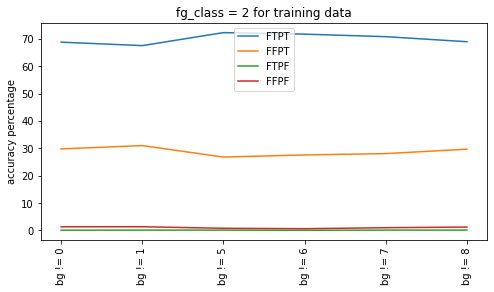

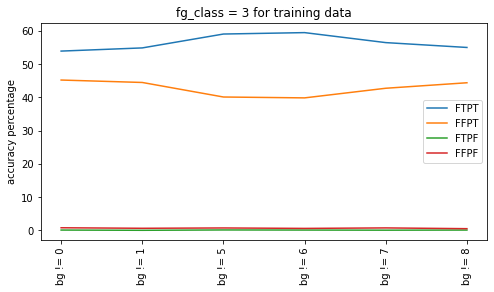

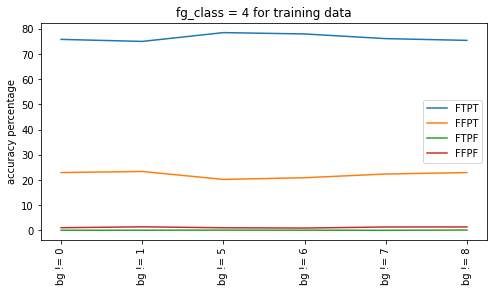

In [102]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

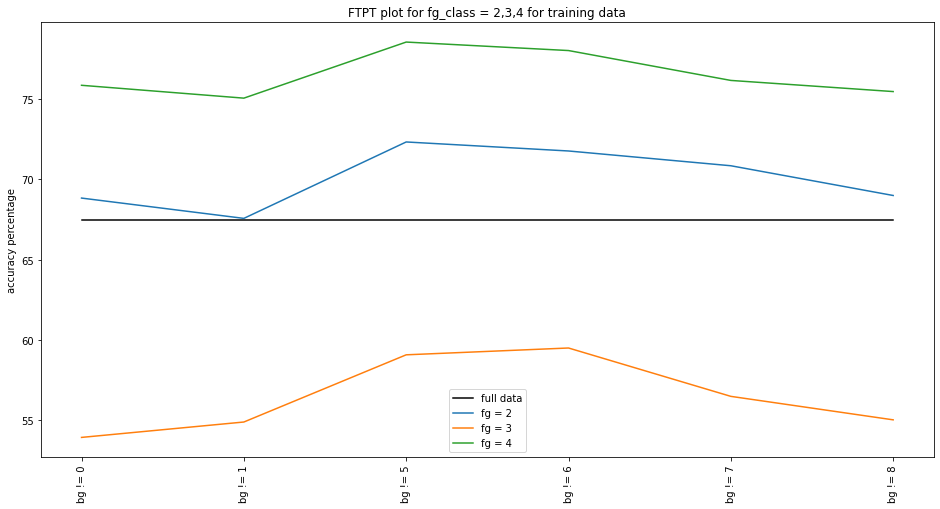

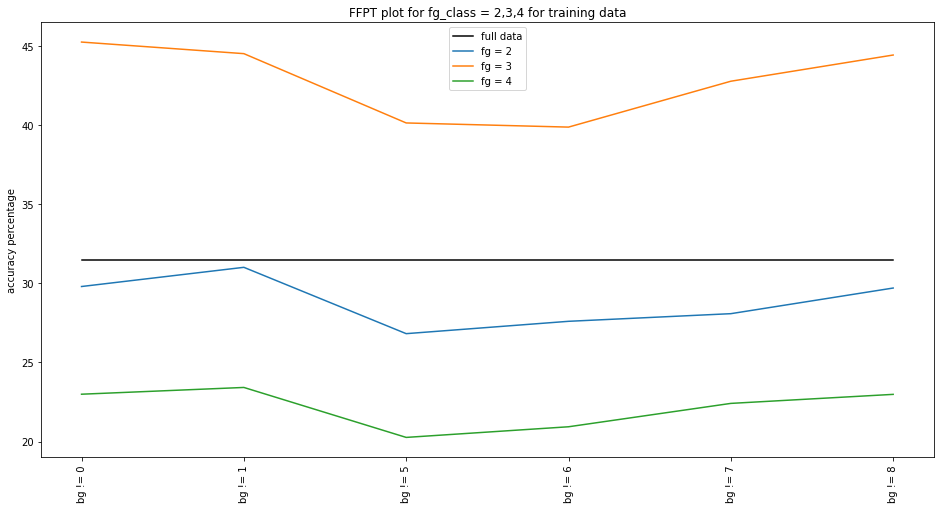

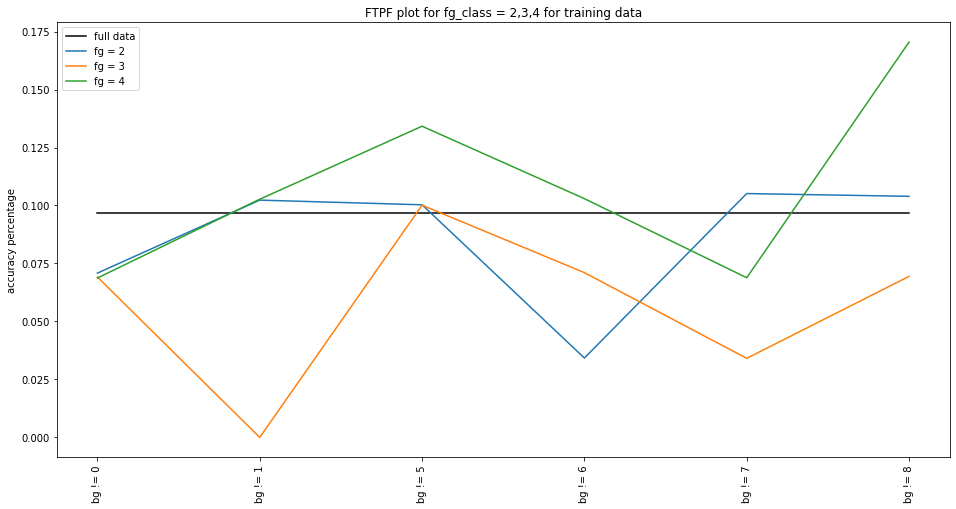

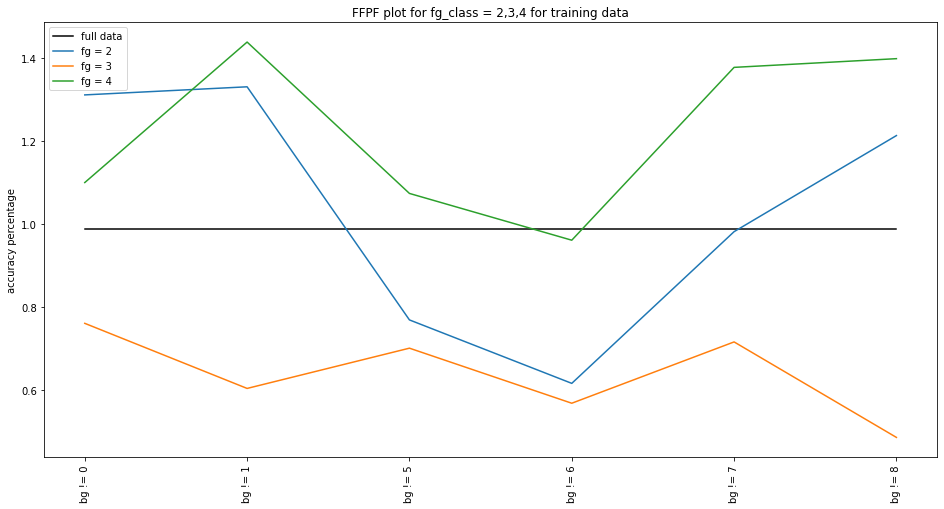

In [103]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [104]:
size1_table=[]
size1_table.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    b1 = i
    count = 0
    correct = 0
    total = 0
    focus_true_pred_true = 0
    focus_false_pred_true = 0
    focus_true_pred_false = 0
    focus_false_pred_false = 0
    argmax_more_than_half = 0
    argmax_less_than_half = 0
    with torch.no_grad():
      for data in test_set:
        inputs, labels , fore_idx = data
        inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for m in range(labels.size(0)):
          # count
          if(count == 10000):
            break
          s = list_set_labels[count]
          # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
          if (a in s and b1 not in s ):
            # print(str(a)+str(b1)+str(b2)+str(b3))
            total += 1
            focus = torch.argmax(alphas[m])
            if alphas[m][focus] >= 0.5 :
              argmax_more_than_half += 1
            else:
              argmax_less_than_half += 1

            if(focus == fore_idx[m] and predicted[m] == labels[m]):
                focus_true_pred_true += 1
            elif(focus != fore_idx[m] and predicted[m] == labels[m]):
              focus_false_pred_true += 1
            elif(focus == fore_idx[m] and predicted[m] != labels[m]):
              focus_true_pred_false += 1
            elif(focus != fore_idx[m] and predicted[m] != labels[m]):
              focus_false_pred_false += 1
          
          count += 1
        
      correct += (predicted == labels).sum().item()  
      entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1), total]
      if total == 0:
        entry.append(0)
        entry.append(0)
        entry.append(0)
        entry.append(0)
      else:
        entry.append((100 * focus_true_pred_true / total))
        entry.append( (100 * focus_false_pred_true / total))
        entry.append( ( 100 * focus_true_pred_false / total))
        entry.append( ( 100 * focus_false_pred_false / total))
      entry.append( argmax_more_than_half)
      size1_table.append(entry)
      entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size1_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000    56.44      14.14      7.41       22.01               7032
      2  fg = 2          bg != 0                               971    55.5098    14.3151    7.41504    22.76                678
      3  fg = 2          bg != 1                               938    55.0107    13.4328    7.67591    23.8806              657
      4  fg = 2          bg != 5                              1016    52.5591    14.6654    9.54724    23.2283              726
      5  fg = 2          bg != 6                               999    55.7558    14.4144    8.50851    21.3213              697
      6  fg = 2          bg != 7                      

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size1_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size1_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size1_table[i])

In [106]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size1_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  22.010000           7032
1      2          fg = 2  ...  22.760041            678
2      3          fg = 2  ...  23.880597            657
3      4          fg = 2  ...  23.228346            726
4      5          fg = 2  ...  21.321321            697

[5 rows x 9 columns]

In [107]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,7  
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0)

l,u = 8,14
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1)

l,u = 15,21
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2)

56.44 14.14 7.41 22.01
[55.50978372811535 55.01066098081024 52.559055118110244 55.75575575575576
 56.16016427104723 56.16580310880829]
[58.02997858672378 54.940711462450594 58.0 58.569926393270244
 58.58798735511065 56.01300108342362]
[57.08418891170431 58.37563451776651 55.04032258064516 57.230142566191454
 55.06519558676028 57.56613756613756]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size1/test/"

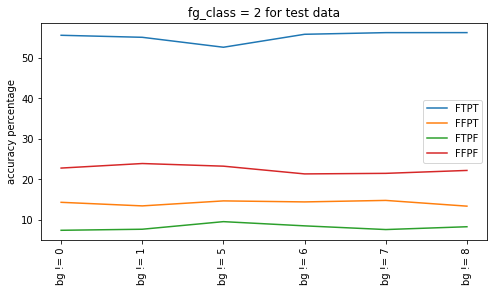

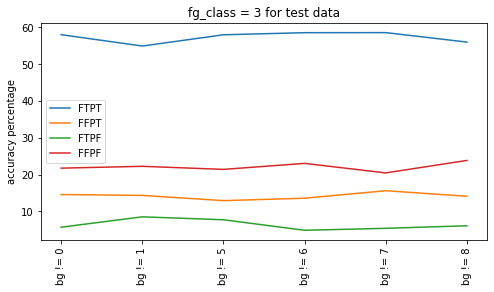

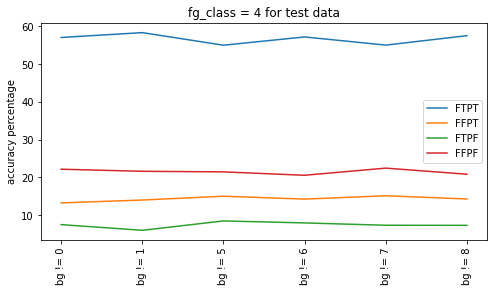

In [109]:
fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (8,4))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

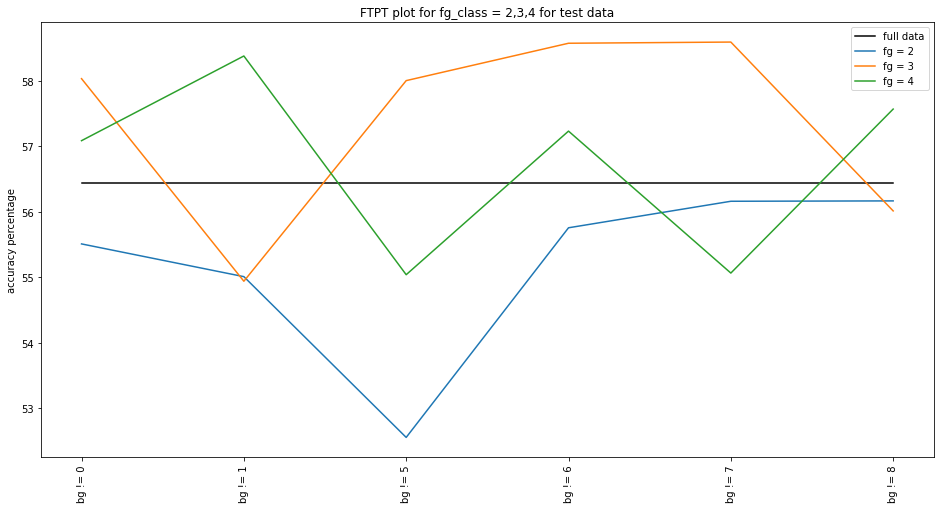

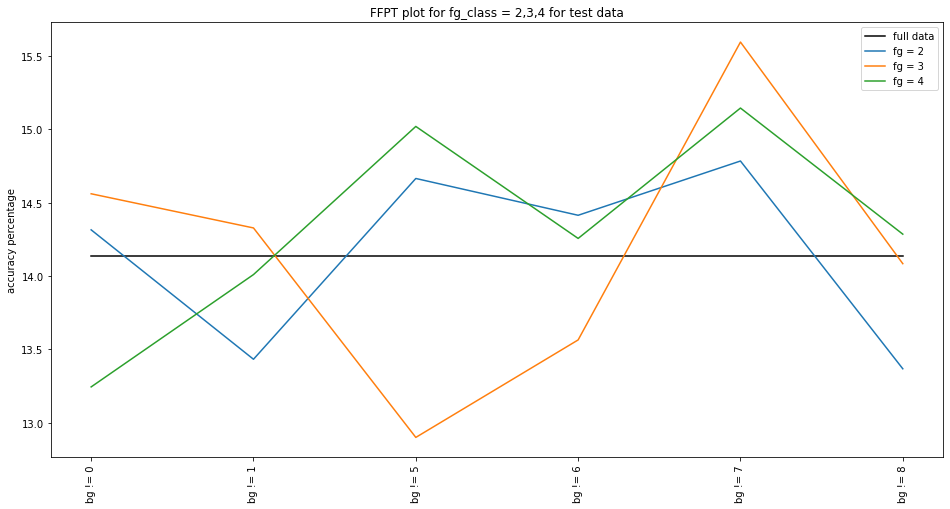

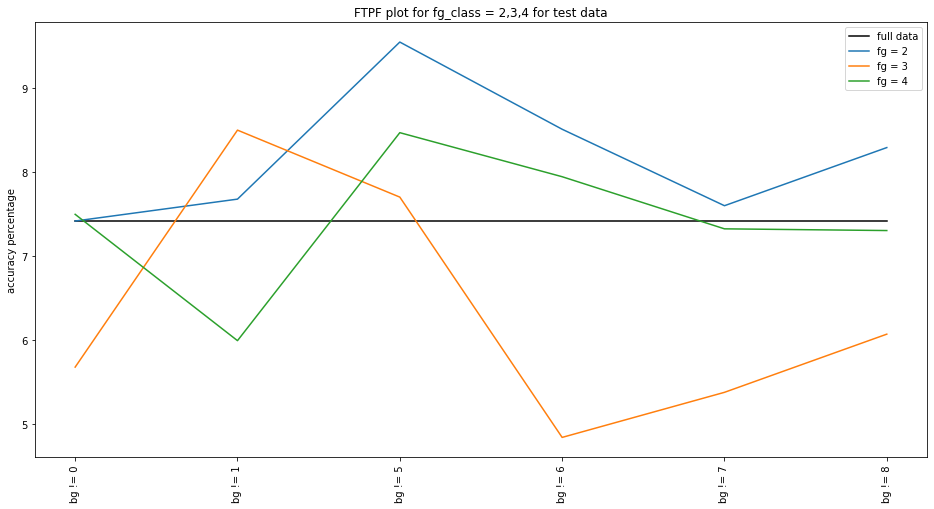

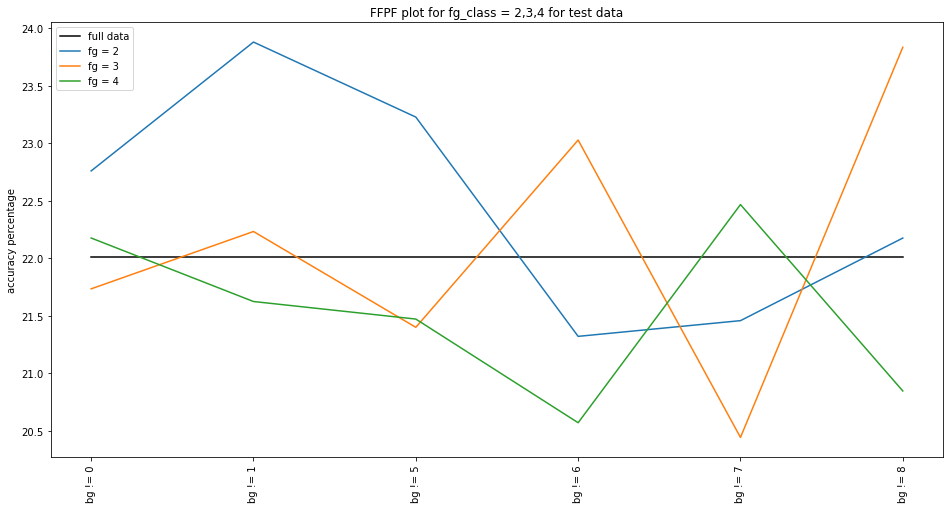

In [110]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 2 , Repetition allowed
## 33 in BG, 34 in BG, 35 in BG and so on
## On Training DATA


In [111]:
size2_table=[]
size2_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1, b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in train_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 30000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 not in s and b2 not in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1) + str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table.append(entry)
        entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size2_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000    67.4733    31.4433  0.0966667   0.986667            22596
      2  fg = 2          bg != 00                             2823    68.8275    29.791   0.0708466   1.31066              2192
      3  fg = 2          bg != 01                              631    66.878     31.3788  0.158479    1.58479               478
      4  fg = 2          bg != 05                              679    70.6922    27.6878  0.147275    1.47275               535
      5  fg = 2          bg != 06                              631    70.8399    28.2092  0           0.950872              496
      6  fg = 2          bg != 07                 

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size2_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table[i])

In [113]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size2_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  0.986667          22596
1      2          fg = 2  ...  1.310662           2192
2      3          fg = 2  ...  1.584786            478
3      4          fg = 2  ...  1.472754            535
4      5          fg = 2  ...  0.950872            496

[5 rows x 9 columns]

In [114]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 50,98
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

67.47333333333333 31.44333333333333 0.09666666666666666 0.9866666666666668
[68.82748848742473 66.87797147385103 70.69219440353461 70.83993660855785]
[53.94190871369295 52.51076040172166 58.60058309037901 57.443365695792885]
[75.84192439862542 75.14619883040936 78.21917808219176 78.86904761904762]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size2/train/"

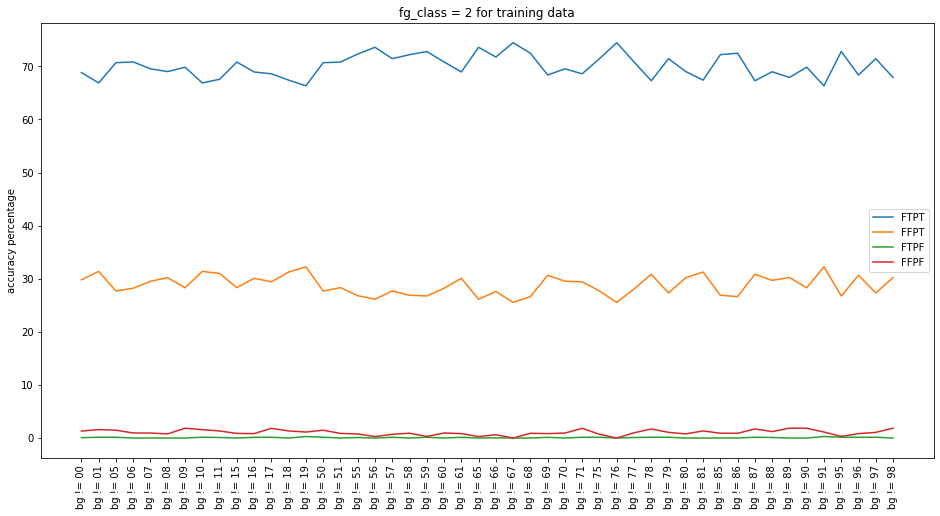

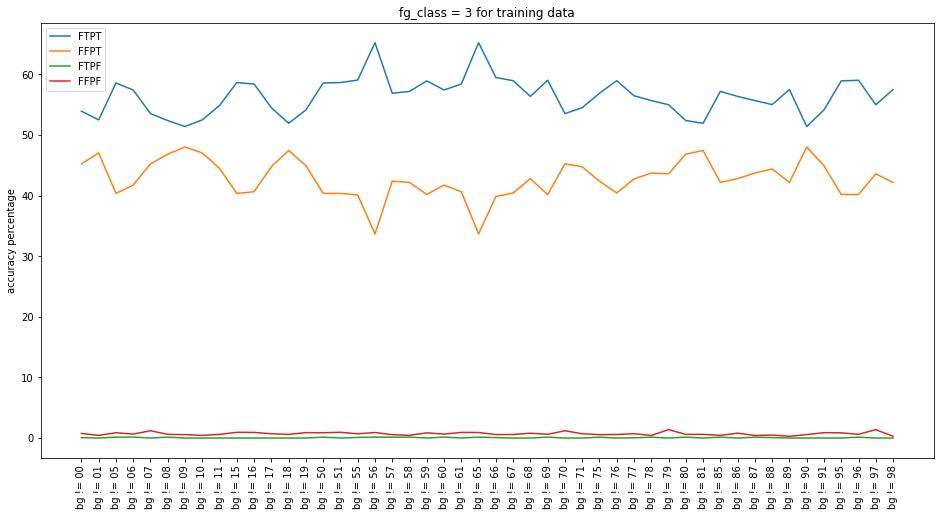

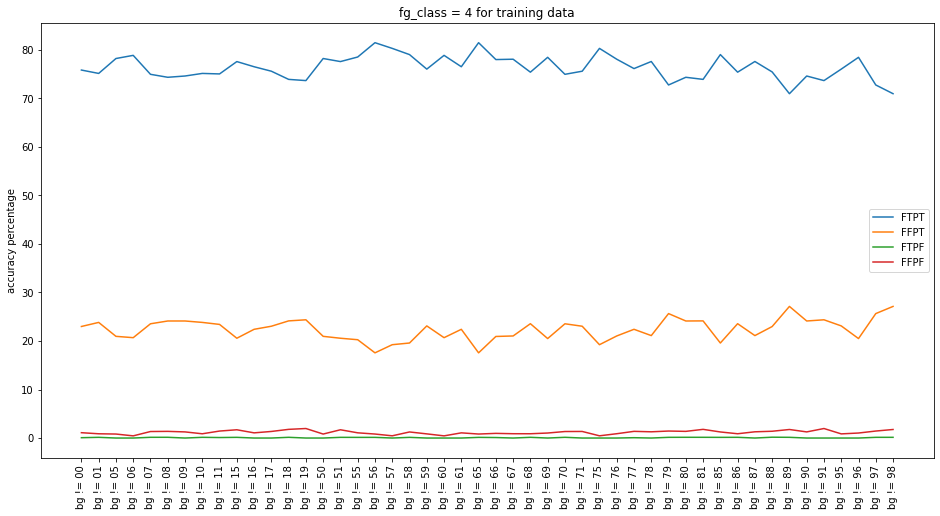

In [116]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

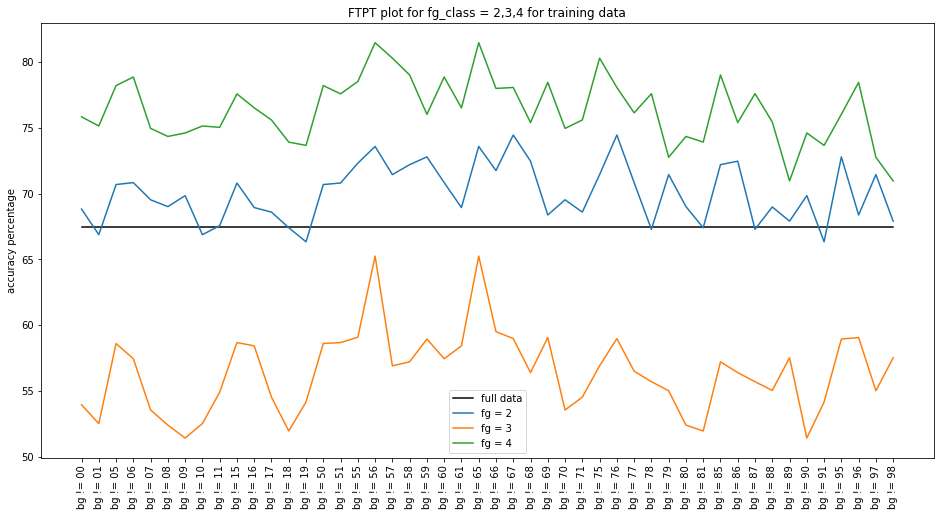

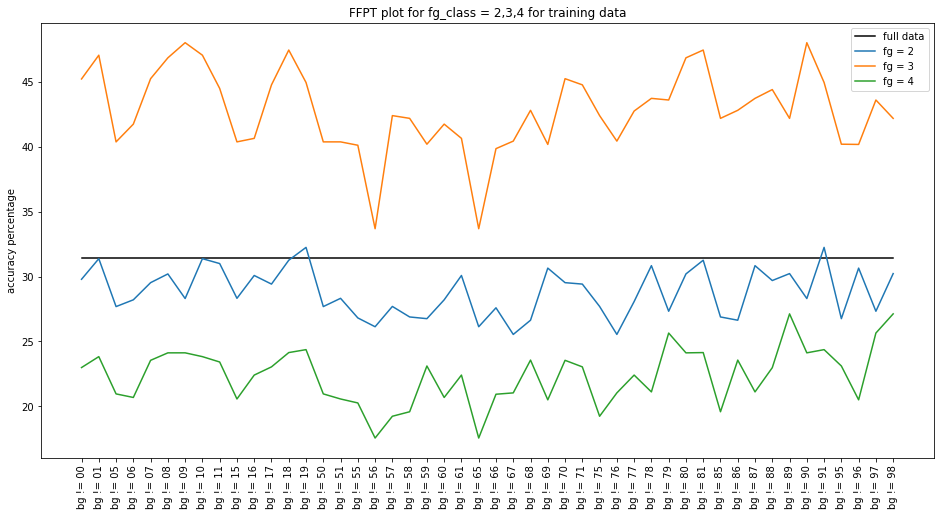

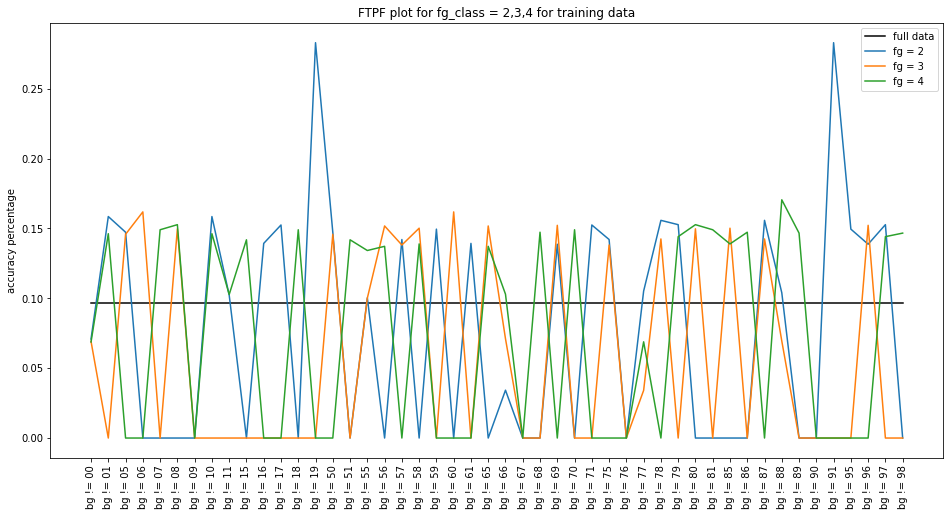

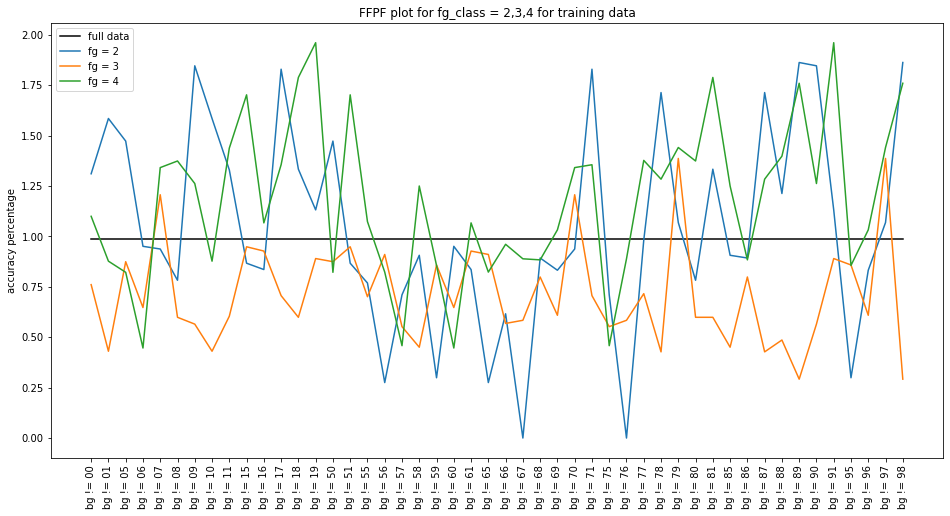

In [117]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [118]:
size2_table_test=[]
size2_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      b1,b2 = i,j
      count = 0
      correct = 0
      total = 0
      focus_true_pred_true = 0
      focus_false_pred_true = 0
      focus_true_pred_false = 0
      focus_false_pred_false = 0
      argmax_more_than_half = 0
      argmax_less_than_half = 0
      with torch.no_grad():
        for data in test_set:
          inputs, labels , fore_idx = data
          inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
          outputs, alphas, avg_images = fore_net(inputs)

          _, predicted = torch.max(outputs.data, 1)

          for m in range(labels.size(0)):
            # count
            if(count == 10000):
              break
            s = list_set_labels[count]
            # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
            if (a in s and b1 not in s and b2 not in s ):
              # print(str(a)+str(b1)+str(b2)+str(b3))
              total += 1
              focus = torch.argmax(alphas[m])
              if alphas[m][focus] >= 0.5 :
                argmax_more_than_half += 1
              else:
                argmax_less_than_half += 1

              if(focus == fore_idx[m] and predicted[m] == labels[m]):
                  focus_true_pred_true += 1
              elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                focus_false_pred_true += 1
              elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                focus_true_pred_false += 1
              elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                focus_false_pred_false += 1
            
            count += 1
          
        correct += (predicted == labels).sum().item()  
        entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1)+str(b2), total]
        if total == 0:
          entry.append(0)
          entry.append(0)
          entry.append(0)
          entry.append(0)
        else:
          entry.append((100 * focus_true_pred_true / total))
          entry.append( (100 * focus_false_pred_true / total))
          entry.append( ( 100 * focus_true_pred_false / total))
          entry.append( ( 100 * focus_false_pred_false / total))
        entry.append( argmax_more_than_half)
        size2_table_test.append(entry)
        entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size2_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000    56.44      14.14      7.41       22.01               7032
      2  fg = 2          bg != 00                              971    55.5098    14.3151    7.41504    22.76                678
      3  fg = 2          bg != 01                              207    51.6908    12.5604    8.69565    27.0531              139
      4  fg = 2          bg != 05                              224    50         15.1786    8.48214    26.3393              152
      5  fg = 2          bg != 06                              222    59.009     17.1171    7.65766    16.2162              156
      6  fg = 2          bg != 07                     

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size2_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size2_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size2_table_test[i])

In [120]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size2_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  22.010000           7032
1      2          fg = 2  ...  22.760041            678
2      3          fg = 2  ...  27.053140            139
3      4          fg = 2  ...  26.339286            152
4      5          fg = 2  ...  16.216216            156

[5 rows x 9 columns]

In [121]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,49
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 50,98
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 99,147
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

56.44 14.14 7.41 22.01
[55.50978372811535 51.690821256038646 50.0 59.009009009009006]
[58.02997858672378 57.45614035087719 58.525345622119815 58.15217391304348]
[57.08418891170431 61.4406779661017 54.435483870967744 58.9041095890411]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size2/test/"

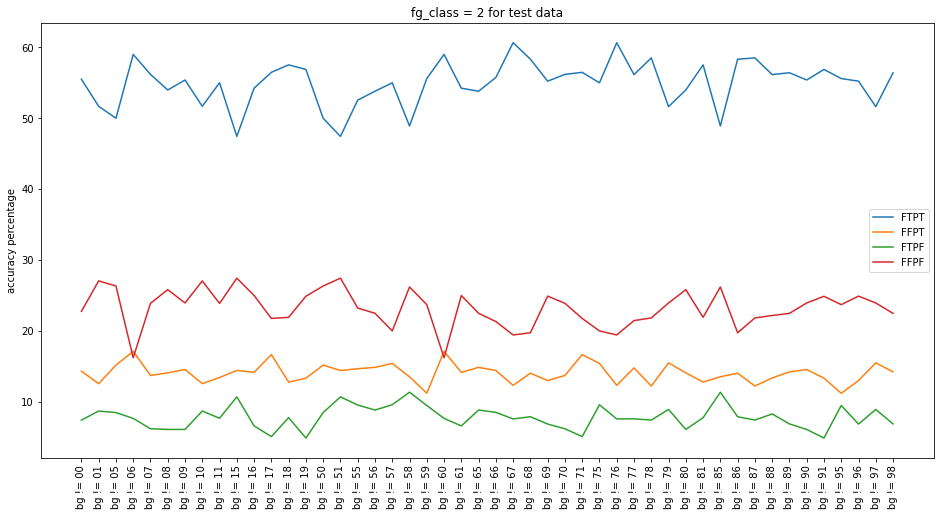

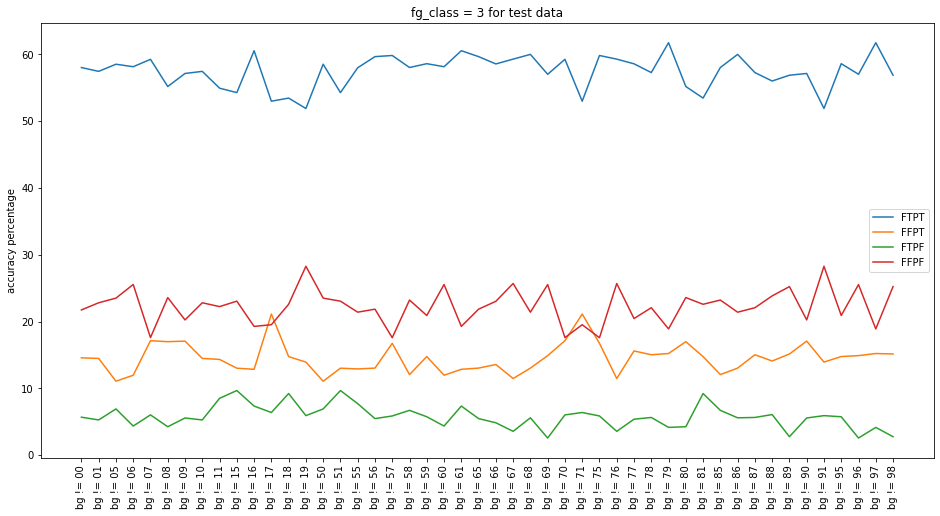

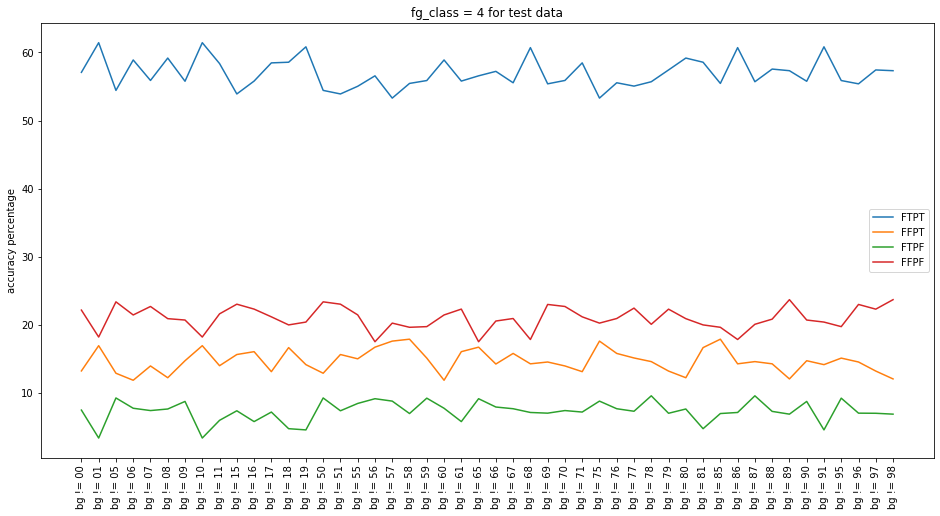

In [123]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

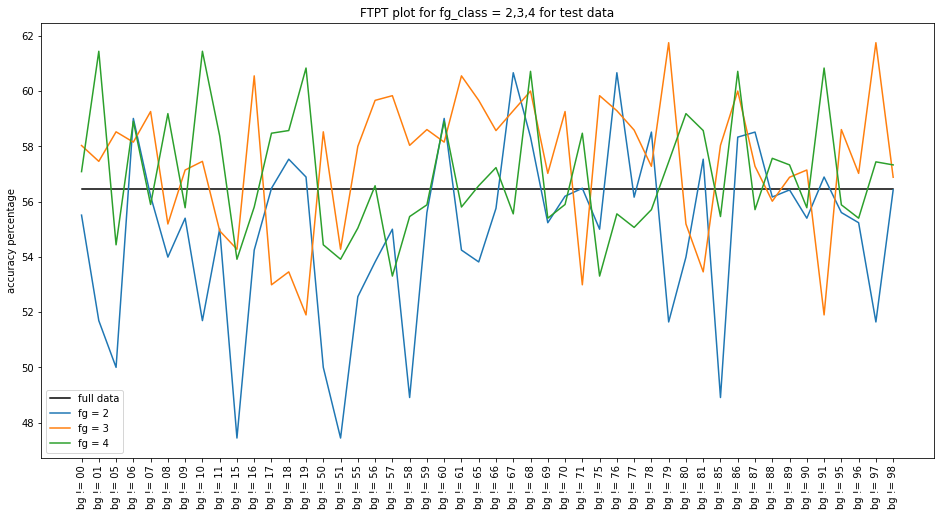

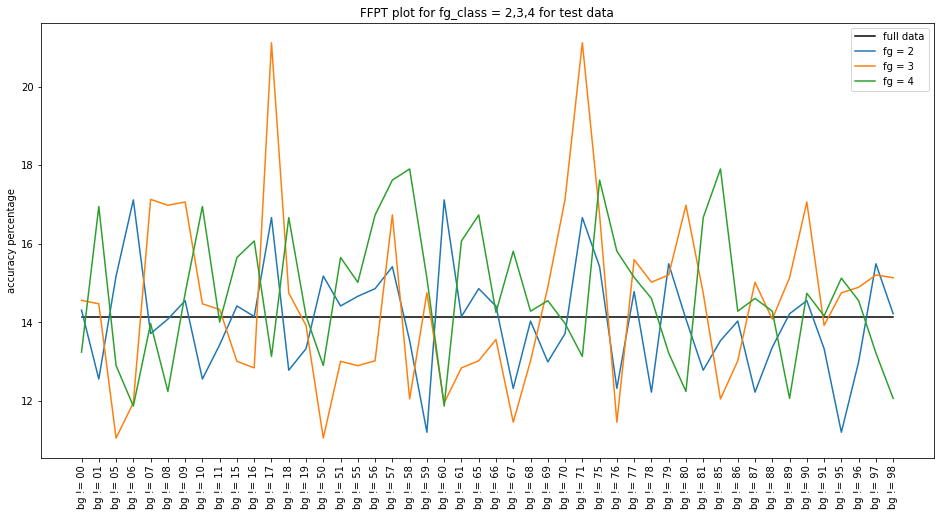

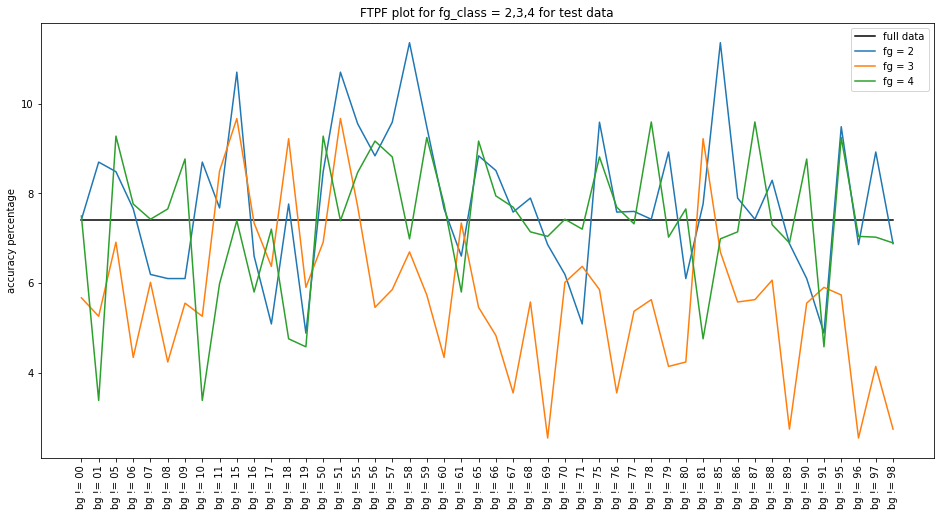

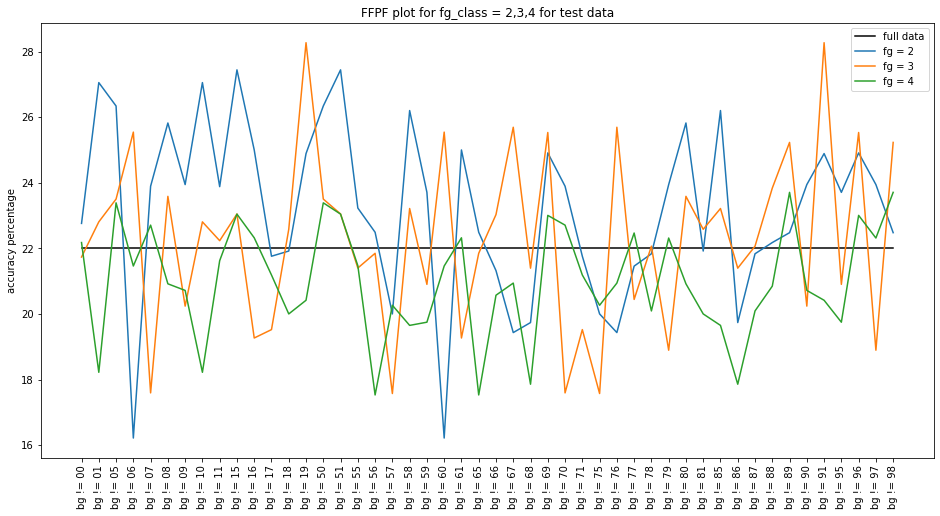

In [124]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

#Set Size 3 , Repetition allowed
## 333 in BG, 334 in BG, 335 in BG and so on
## On Training DATA


In [125]:
size3_table=[]
size3_table.append(train_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1, b2, b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in train_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 30000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 not in s and b2 not in s and b3 not in s ):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg != '+ str(b1) + str(b2) +str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table.append(entry)
          entry_no += 1

print("="*20+"Training DATA"+"="*20)
print(tabulate(size3_table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Training DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          30000    67.4733    31.4433  0.0966667   0.986667            22596
      2  fg = 2          bg != 000                            2823    68.8275    29.791   0.0708466   1.31066              2192
      3  fg = 2          bg != 001                             631    66.878     31.3788  0.158479    1.58479               478
      4  fg = 2          bg != 005                             679    70.6922    27.6878  0.147275    1.47275               535
      5  fg = 2          bg != 006                             631    70.8399    28.2092  0           0.950872              496
      6  fg = 2          bg != 007                

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size3_on_train.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table[i])

In [127]:
train = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size3_on_train.csv")
train.head()

S.No.        fg_class  ...   FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  0.986667          22596
1      2          fg = 2  ...  1.310662           2192
2      3          fg = 2  ...  1.584786            478
3      4          fg = 2  ...  1.472754            535
4      5          fg = 2  ...  0.950872            496

[5 rows x 9 columns]

In [128]:
train = np.array(train)
ftpt_full = train[0][4]
ffpt_full = train[0, 5]
ftpf_full = train[0, 6]
ffpf_full = train[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = train[l:u, 2]
ftpt0 = train[l:u, 4]
ffpt0 = train[l:u, 5]
ftpf0 = train[l:u, 6]
ffpf0 = train[l:u, 7]
print(ftpt0[0:4] )

l,u = 344,686
id1 = train[l:u, 2]
ftpt1 = train[l:u, 4]
ffpt1 = train[l:u, 5]
ftpf1 = train[l:u, 6]
ffpf1 = train[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = train[l:u, 2]
ftpt2 = train[l:u, 4]
ffpt2 = train[l:u, 5]
ftpf2 = train[l:u, 6]
ffpf2 = train[l:u, 7]
print(ftpt2[0:4] )

67.47333333333333 31.44333333333333 0.09666666666666666 0.9866666666666668
[68.82748848742473 66.87797147385103 70.69219440353461 70.83993660855785]
[53.94190871369295 52.51076040172166 58.60058309037901 57.443365695792885]
[75.84192439862542 75.14619883040936 78.21917808219176 78.86904761904762]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size3/train/"

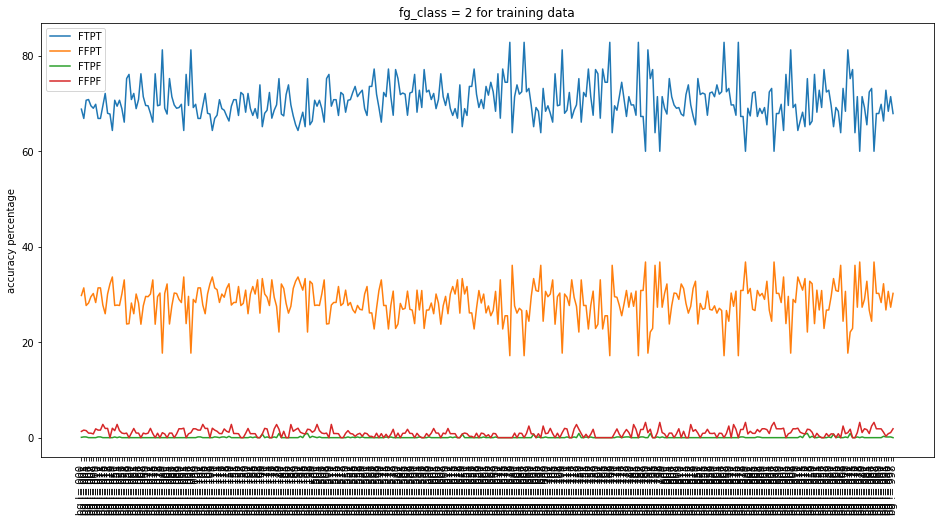

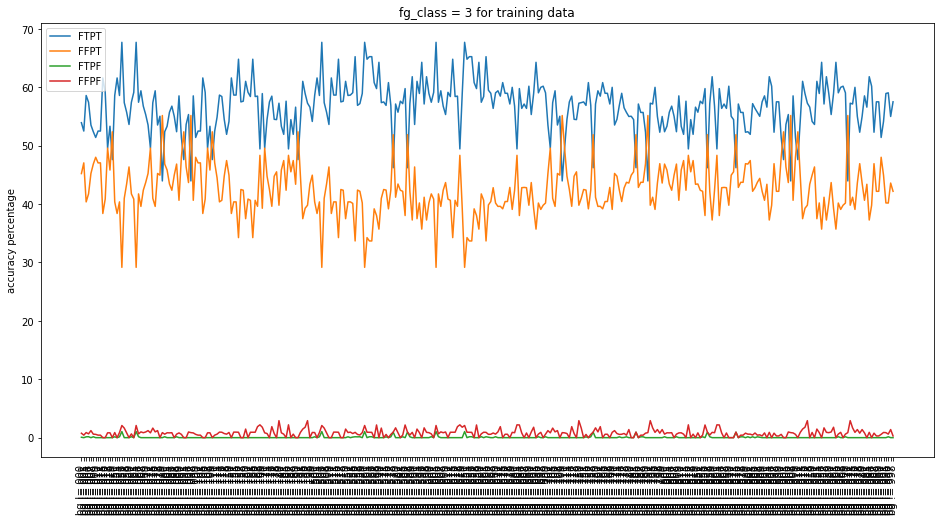

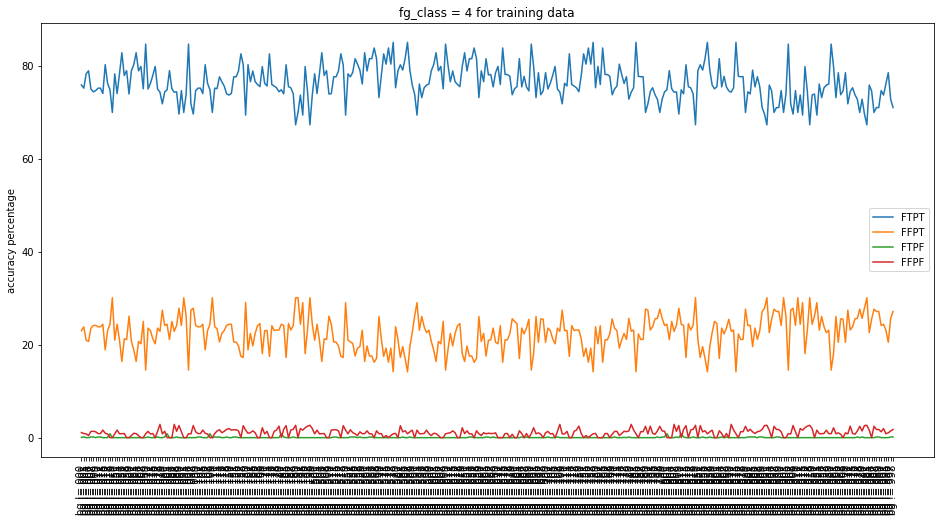

In [130]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for training data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for training data'+".pdf", bbox_inches='tight')

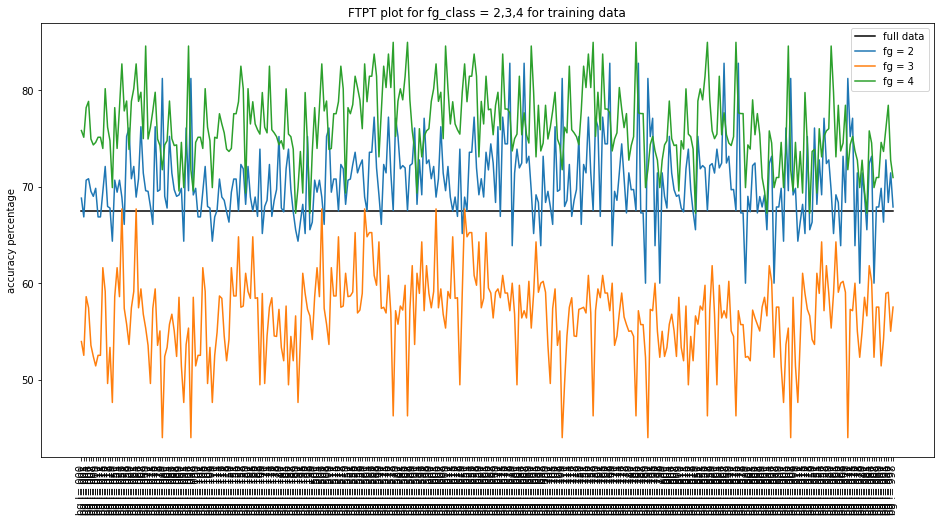

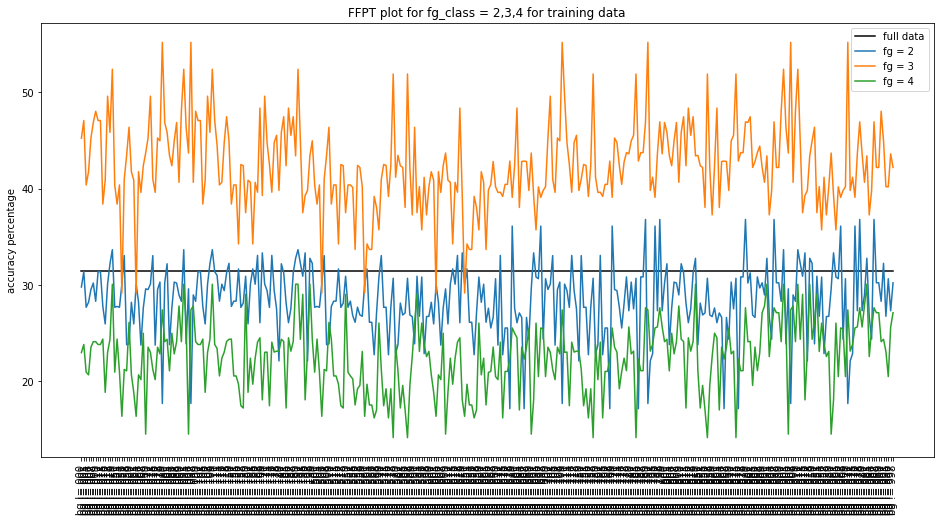

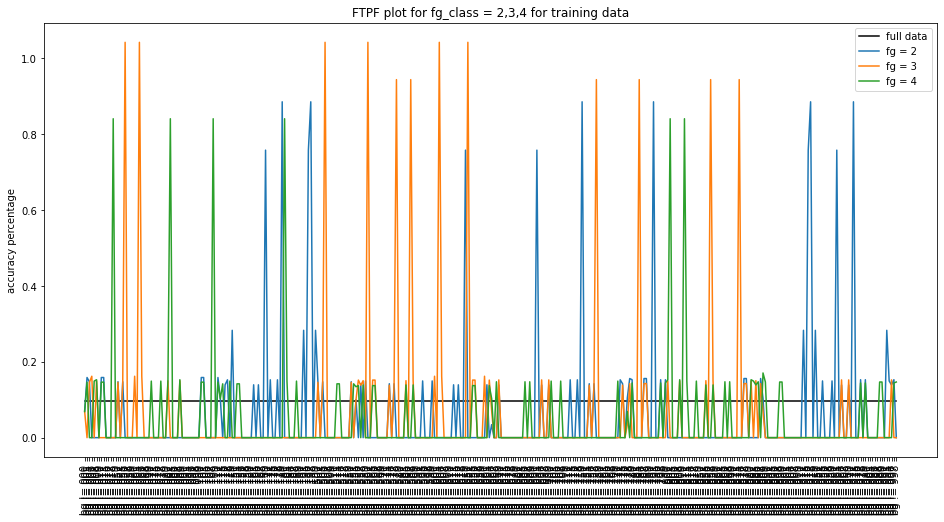

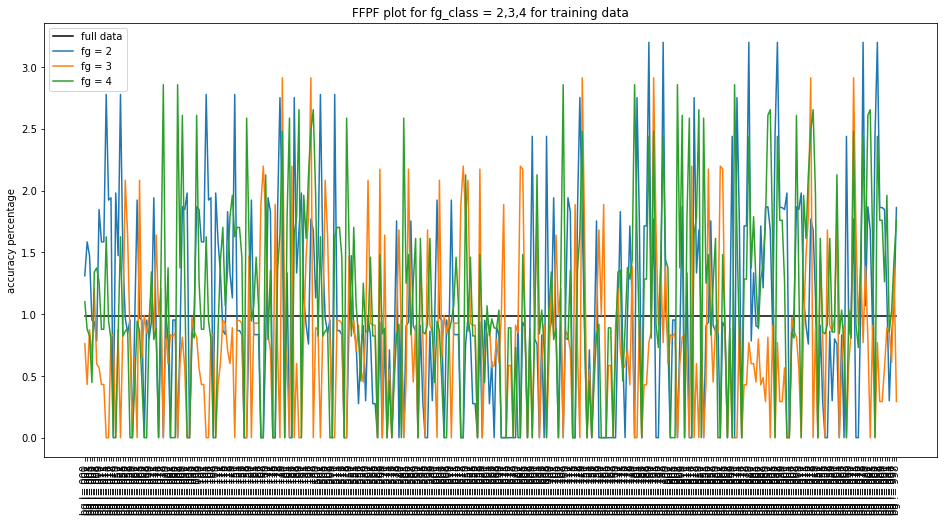

In [131]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for training data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')

## On Test DATA


In [132]:
size3_table_test=[]
size3_table_test.append(test_entry)
entry_no = 2

# cnt=0
for a in fg :
  for i in bg:
    for j in bg:
      for k in bg:
        b1,b2,b3 = i,j,k
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in test_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 10000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 not in s and b2 not in s and b3 not in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+str(b2)+str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          size3_table_test.append(entry)
          entry_no += 1

print("="*20+"Test DATA"+"="*20)
print(tabulate(size3_table_test, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


====================Test DATA====================
  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [2, 3, 4]  bg = [0, 1, 5, 6, 7, 8, 9]          10000    56.44     14.14       7.41      22.01                7032
      2  fg = 2          bg = 000                              971    55.5098   14.3151     7.41504   22.76                 678
      3  fg = 2          bg = 001                              207    51.6908   12.5604     8.69565   27.0531               139
      4  fg = 2          bg = 005                              224    50        15.1786     8.48214   26.3393               152
      5  fg = 2          bg = 006                              222    59.009    17.1171     7.65766   16.2162               156
      6  fg = 2          bg = 007                     

In [0]:
with open("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_" + str(fg_used) + "/" + "size3_on_test.csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(size3_table_test)
  thewriter.writerow(['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(size3_table_test[i])

In [134]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_"+str(fg_used) + "/" + "size3_on_test.csv")
test.head()

S.No.        fg_class  ...    FFPF %   avg_img > 0.5
0      1  fg = [2, 3, 4]  ...  22.010000           7032
1      2          fg = 2  ...  22.760041            678
2      3          fg = 2  ...  27.053140            139
3      4          fg = 2  ...  26.339286            152
4      5          fg = 2  ...  16.216216            156

[5 rows x 9 columns]

In [135]:
test = np.array(test)
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
print(ftpt_full, ffpt_full, ftpf_full, ffpf_full)

l,u = 1,343
id0 = test[l:u, 2]
ftpt0 = test[l:u, 4]
ffpt0 = test[l:u, 5]
ftpf0 = test[l:u, 6]
ffpf0 = test[l:u, 7]
print(ftpt0[0:4])

l,u = 344,686
id1 = test[l:u, 2]
ftpt1 = test[l:u, 4]
ffpt1 = test[l:u, 5]
ftpf1 = test[l:u, 6]
ffpf1 = test[l:u, 7]
print(ftpt1[0:4] )

l,u = 687,1029
id2 = test[l:u, 2]
ftpt2 = test[l:u, 4]
ffpt2 = test[l:u, 5]
ftpf2 = test[l:u, 6]
ffpf2 = test[l:u, 7]
print(ftpt2[0:4] )

56.44 14.14 7.41 22.01
[55.50978372811535 51.690821256038646 50.0 59.009009009009006]
[58.02997858672378 57.45614035087719 58.525345622119815 58.15217391304348]
[57.08418891170431 61.4406779661017 54.435483870967744 58.9041095890411]


In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/phase3/fg_' + str(fg_used) + "/size3/test/"

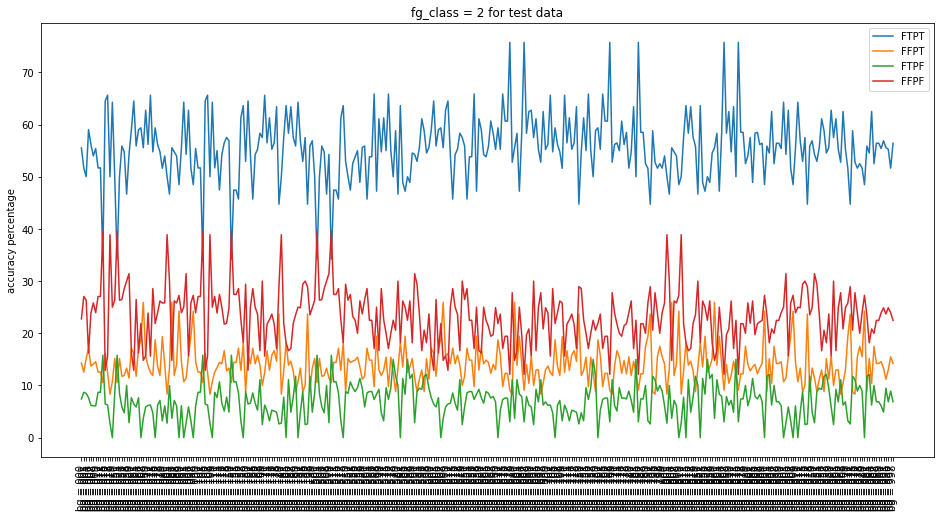

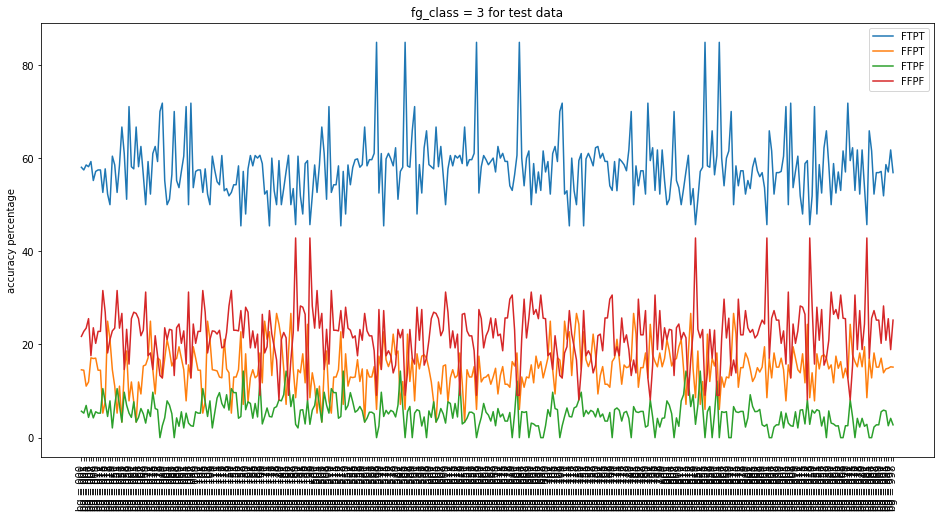

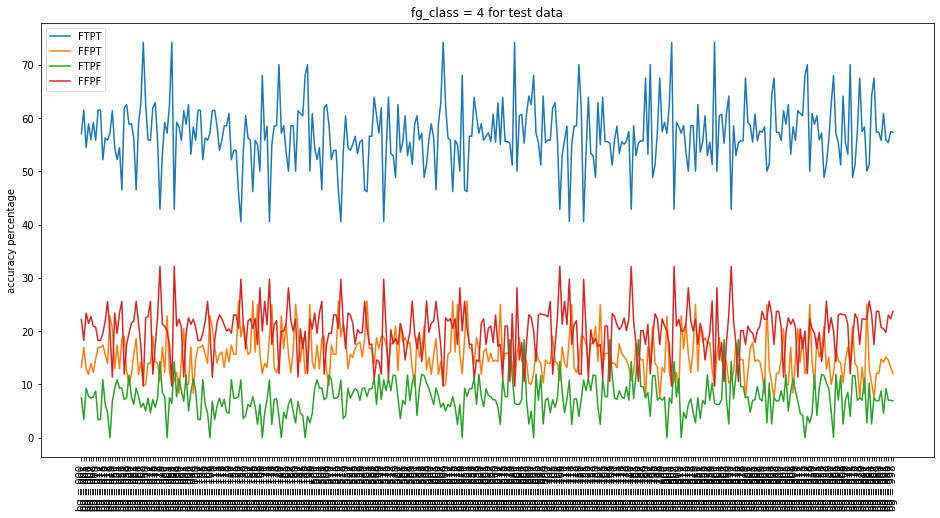

In [137]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+' for test data'+".pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+' for test data'+".pdf", bbox_inches='tight')

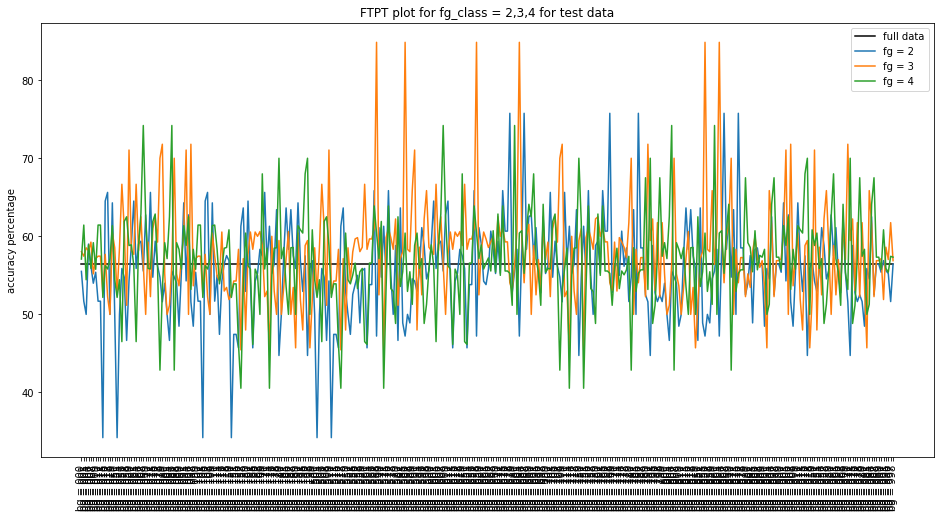

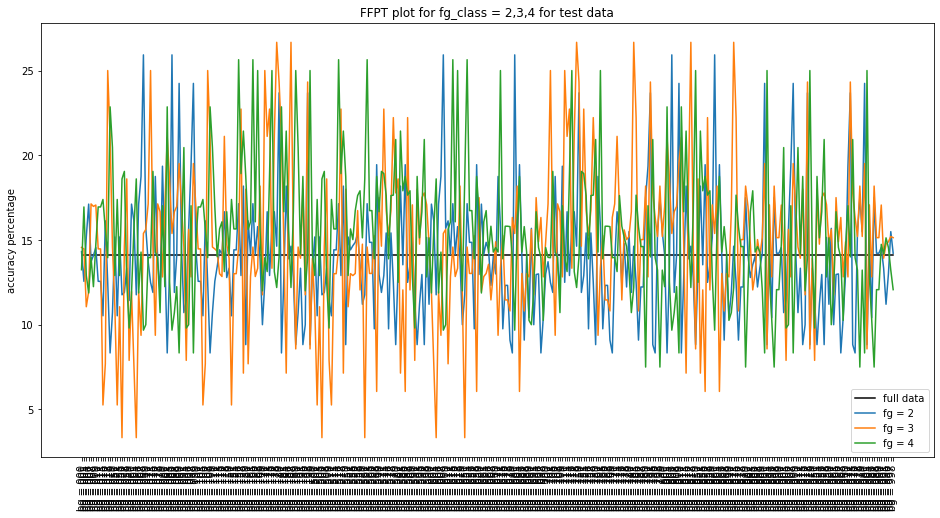

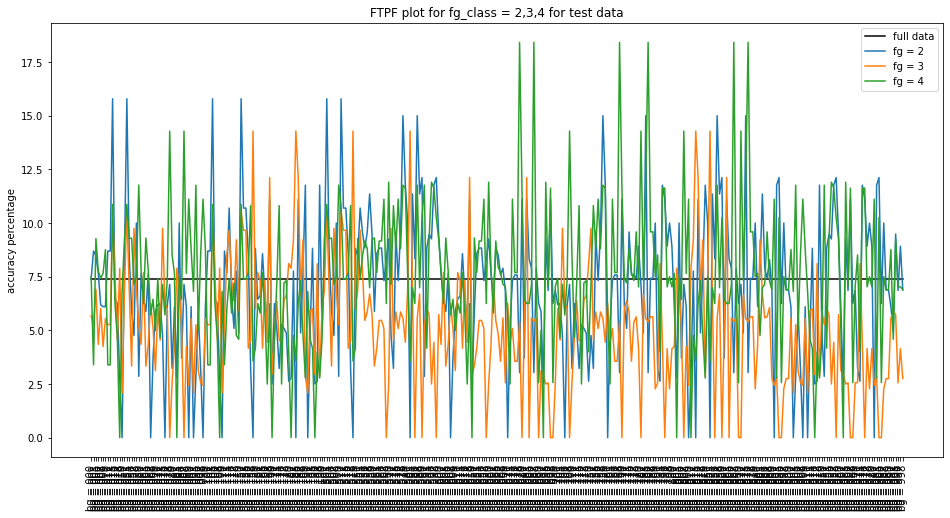

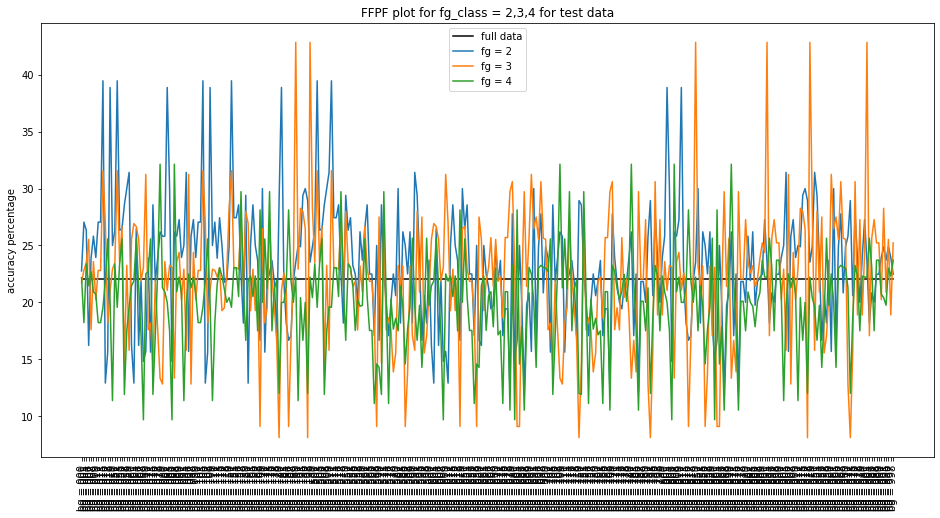

In [138]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3)+' for test data')
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')